In [2]:
import json, sys, os, glob
import pandas as pd
from datetime import date, time, datetime, timedelta
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

In [5]:
def csv_to_df(symbol, base_tf="1d"):
    folder_path = f"./data/spot/monthly/klines/{symbol}/{base_tf}/2017-07-01_2022-04-01/"
    col_names = ['ts', 'open', 'high', 'low', 'close', 'volume', 'close_ts', 'asset_volume', 'num_trades', 'i','d','k']
    #Put csv data into pandas dataframe
    all_files = glob.glob(folder_path + "*.csv")
    df_list = (pd.read_csv(f, names=col_names, usecols=[0, 1, 2, 3, 4, 5], index_col=0) for f in all_files)
    df = pd.concat(df_list)

    #Convert epoch int into actual datetime
    df.index = df.index.map(lambda x: datetime.utcfromtimestamp(int(x)/1000))
    return df

btc = csv_to_df("BTCUSDT")
eth = csv_to_df("ETHUSDT")

In [6]:
btc.head()
eth.head()

,open,high,low,close,volume
ts,,,,,
2017-08-17,301.13,312.18,298.00,302.00,7030.71034
2017-08-18,302.00,311.79,283.94,293.96,9537.84646
2017-08-19,293.31,299.90,278.00,290.91,2146.19773
2017-08-20,289.41,300.53,282.85,299.10,2510.13871
2017-08-21,299.10,346.52,294.60,323.29,5219.44542


y2 is 0.5002963841137671 behind y1


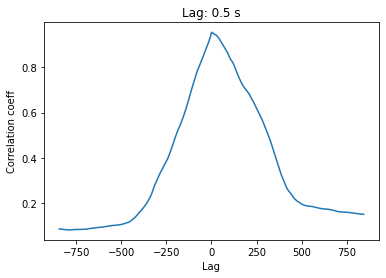

In [7]:
def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

# Sine sample with some noise and copy to y1 and y2 with a 1-second lag
sr = 1
# y = np.linspace(0, 2*np.pi, sr)
# y = np.tile(np.sin(y), 5)
# y += np.random.normal(0, 5, y.shape)
# y1 = y[sr:4*sr]
# y2 = y[:3*sr]

lag_finder(btc['close'], eth['close'], sr)